## Sea Ice 

Plot sea ice extent around Antarctica for a set of CESM2-MOM6 simulations.

In [4]:
import os
import sys
sys.path.insert(1,'/glade/u/home/yhoussam/analysis/mom6_diagnostics')
from analysis_mom6 import *
import matplotlib.pyplot as plt
import cmocean
from cartopy import crs as ccrs
from tqdm import tqdm
import colorcet as cc
from collections import OrderedDict
import pandas as pd

data_path = '/glade/u/home/yhoussam/analysis/simulations/data/'
def return_ncfile_path(analysis_dir,sim,file):
    nc_dir = os.path.join(analysis_dir,sim)
    nc_dir = os.path.join(nc_dir,'ncfiles')
    file_name = sim+'_'+file+'.nc'
    path =  os.path.join(nc_dir,file_name)
    return path


import warnings
from xarray.coding.times import SerializationWarning

warnings.filterwarnings(
    "ignore",
    "Unable to decode time axis into full numpy.datetime64 objects",
    category=SerializationWarning
)

def resolution(R,alpha,p):
    return 1./(1+(alpha*R)**p)


save_path = 'png/'
import matplotlib as mpl
mpl.rcParams['font.size'] = 20

import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
})

In [5]:
case_names = ['gmom.e23.GJRAv3.TL319_t025_hycom1_N75.tx1_4.smag_control.003',
              'gmom.e23.GJRAv3.TL319_t025_hycom1_N75.tx1_4.MEKE_GM.004',
              'gmom.e23.GJRAv3.TL319_t025_hycom1_N75.tx1_4.MEKE_GM.007',
              'gmom.e23.GJRAv3.TL319_t025_hycom1_N75.tx1_4.leith_GM.028'
              ]
snames = ['REF','GM','GM+MBK','GM+LBK']

loc = 'archive'

sims = []
for i in range(len(snames)):
    sim = MOM6_simulation(snames[i],case_names[i],loc=loc)
    sims.append(sim)

num_sims = len(sims)

start_date = '0051-01-01'
end_date = '0061-12-31'
start_year = int(start_date[:4])
end_year = int(end_date[:4])



fs = 15

alpha_res = 2.
p_res = 50

In [6]:
from ncar_jobqueue import NCARCluster
from dask.distributed import Client
nw = 6

parallel = False
if nw > 1:
    parallel = True
    cluster = NCARCluster(interface='ext',project='P93300012',walltime='04:00:00')
    cluster.scale(nw)
    client = Client(cluster)

/glade/work/yhoussam/conda-envs/mom6_solutions/lib/python3.8/site-packages/dask_jobqueue/core.py:255: FutureWarning: job_extra has been renamed to job_extra_directives. You are still using it (even if only set to []; please also check config files). If you did not set job_extra_directives yet, job_extra will be respected for now, but it will be removed in a future release. If you already set job_extra_directives, job_extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/glade/work/yhoussam/conda-envs/mom6_solutions/lib/python3.8/site-packages/dask_jobqueue/core.py:274: FutureWarning: env_extra has been renamed to job_script_prologue. You are still using it (even if only set to []; please also check config files). If you did not set job_script_prologue yet, env_extra will be respected for now, but it will be removed in a future release. If you already set job_script_prologue, env_extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/glade/

In [7]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/yhoussam/proxy/45613/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/yhoussam/proxy/45613/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://128.117.208.174:38497,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/yhoussam/proxy/45613/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [8]:
%%time
res_funcs = []

for i in range(num_sims):
    sim = MOM6_simulation(snames[i],case_names[i],loc=loc)
    sim.open_files_by_year(sim.ocn_data_path, sim.native_end, start_year, end_year)
    sim.open_grid()
    sim.ds = sim.ds.sel(time=slice(start_date,end_date))
    Rd_dx = sim.ds.Rd_dx.mean('time').compute()

    res_func = resolution(Rd_dx,alpha_res,p_res)
    res_funcs.append(res_func)


Task exception was never retrieved
future: <Task finished name='Task-433' coro=<Client._gather.<locals>.wait() done, defined at /glade/work/yhoussam/conda-envs/mom6_solutions/lib/python3.8/site-packages/distributed/client.py:2189> exception=AllExit()>
Traceback (most recent call last):
  File "/glade/work/yhoussam/conda-envs/mom6_solutions/lib/python3.8/site-packages/distributed/client.py", line 2198, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-422' coro=<Client._gather.<locals>.wait() done, defined at /glade/work/yhoussam/conda-envs/mom6_solutions/lib/python3.8/site-packages/distributed/client.py:2189> exception=AllExit()>
Traceback (most recent call last):
  File "/glade/work/yhoussam/conda-envs/mom6_solutions/lib/python3.8/site-packages/distributed/client.py", line 2198, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-431' coro=<

In [12]:
%%time

for i in range(num_sims):
    sim = sims[i]
    sim.open_files_by_year(sim.ice_data_path, "", start_year, end_year)
    sim.open_grid()


Opened 132 files (0051-0061)
Opened grid and assigned coordinates.
Opened 132 files (0051-0061)
Opened grid and assigned coordinates.
Opened 132 files (0051-0061)
Opened grid and assigned coordinates.
Opened 132 files (0051-0061)
Opened grid and assigned coordinates.
CPU times: user 25.7 s, sys: 2.9 s, total: 28.5 s
Wall time: 1min 3s


In [13]:
sims[0].ds.aice

<xarray.DataArray 'aice' (time: 132, nj: 1080, ni: 1440)>
dask.array<concatenate, shape=(132, 1080, 1440), dtype=float32, chunksize=(1, 1080, 1440), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 0051-01-16 12:00:00 ... 0061-12-16 12:00:00
    TLON     (time, nj, ni) float32 dask.array<chunksize=(1, 1080, 1440), meta=np.ndarray>
    TLAT     (time, nj, ni) float32 dask.array<chunksize=(1, 1080, 1440), meta=np.ndarray>
    ULON     (time, nj, ni) float32 dask.array<chunksize=(1, 1080, 1440), meta=np.ndarray>
    ULAT     (time, nj, ni) float32 dask.array<chunksize=(1, 1080, 1440), meta=np.ndarray>
    NLON     (time, nj, ni) float32 dask.array<chunksize=(1, 1080, 1440), meta=np.ndarray>
    NLAT     (time, nj, ni) float32 dask.array<chunksize=(1, 1080, 1440), meta=np.ndarray>
    ELON     (time, nj, ni) float32 dask.array<chunksize=(1, 1080, 1440), meta=np.ndarray>
    ELAT     (time, nj, ni) float32 dask.array<chunksize=(1, 1080, 1440), meta=np.ndarray>
Dimensions without coordinates: nj, ni
Attributes:
    units:          1
    long_name:      ice area  (aggregate)
    cell_measures:  area: tarea
    cell_methods:   time: mean
    time_rep:       averaged

In [11]:
clim_start = '0060-01-01'
clim_end   = '0061-12-31'

sept_means = {}

for sim in tqdm(sims, desc="Computing Sept climatologies"):
    # 1) Select the aice field over the climatology period
    aice = sim.ds['aice'].sel(time=slice(clim_start, clim_end))
    
    # 2) Select only September slices
    sept = aice.sel(time=aice.time.dt.month == 9)
    
    # 3) Compute the mean over all those Septembers
    sept_mean = sept.mean(dim='time', skipna=False).compute()
    
    # 4) Store in dict keyed by sim name
    sept_means[sim.short_name] = sept_mean


Computing Sept climatologies:   0%|          | 0/4 [00:00<?, ?it/s]


TypeError: 'NoneType' object is not subscriptable

CPU times: user 13.4 s, sys: 152 ms, total: 13.5 s
Wall time: 15.6 s


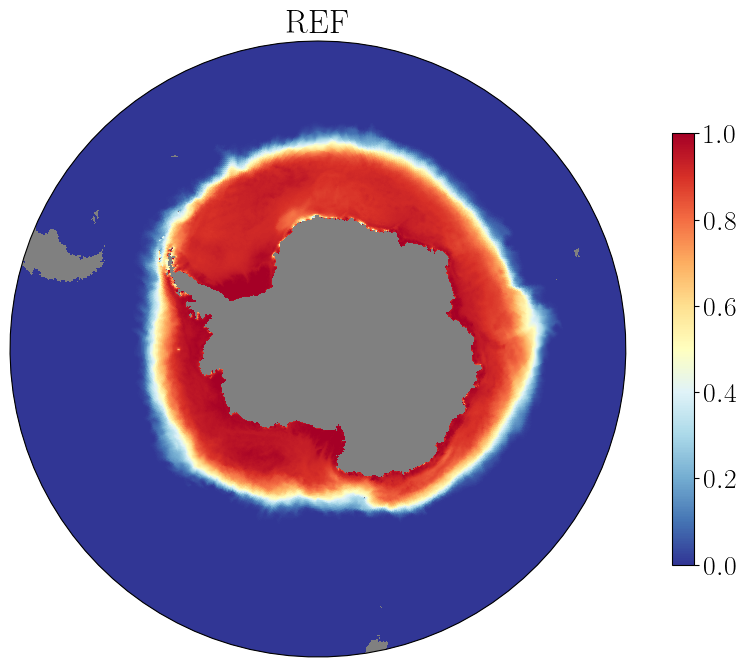

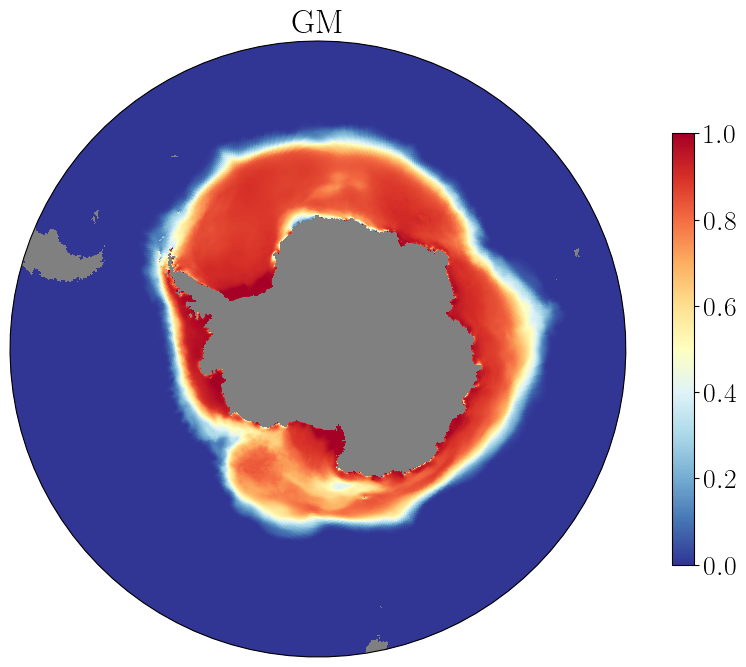

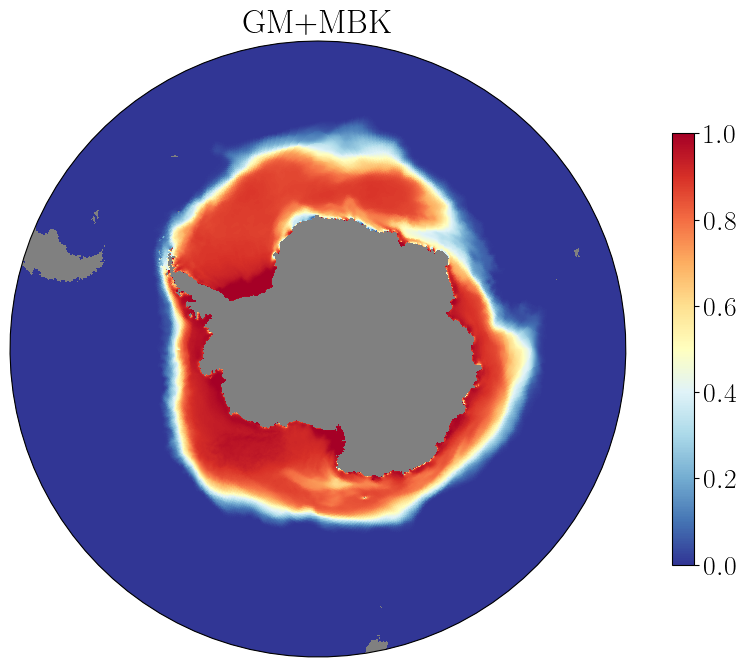

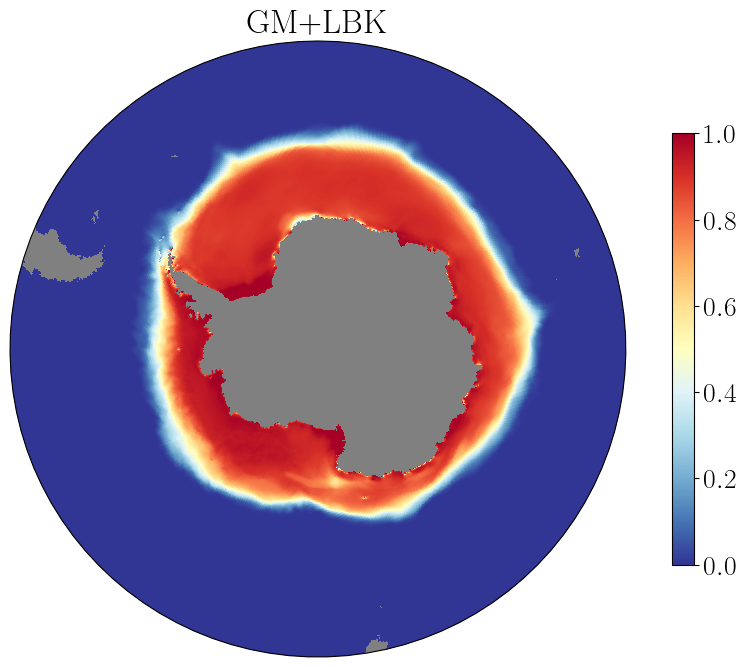

In [10]:
%%time
top = -45
for i in range(num_sims):
    sim = sims[i]
    field = sept_means[sim.short_name]
    ULON2d = sim.ds['ULON'].isel(time=0)
    ULAT2d = sim.ds['ULAT'].isel(time=0)
    field = field.assign_coords({
        'ULON': (ULON2d.dims, ULON2d.values),
        'ULAT': (ULAT2d.dims, ULAT2d.values),
    })

    title = sim.short_name
    sim.plot_antarctica(field,vmin=0,vmax=1,top=top,
                    x='ULON',y='ULAT',
                    cmap=cm.RdYlBu_r,cbar_label= r'',
                    title=title,
                    cbar_size=0.7,figsize=(12,8))

    import matplotlib.ticker as mticker

    ax = plt.gca()
    ax.grid(True, which='both', linestyle='--', color='gray', linewidth=0.5)
    ax.xaxis.set_major_locator(mticker.MultipleLocator(30))  # adjust as needed (e.g., every 30°)
    plt.savefig(save_path+"SeaIceMap"+title+'.png',dpi=300)   

In [ ]:
diffs = []
for sim in sims[1:]:
    diff = sept_means[sim.short_name].fillna(0)-sept_means['REF'].fillna(0)
    ULON2d = sim.ds['ULON'].isel(time=0)
    ULAT2d = sim.ds['ULAT'].isel(time=0)
    diff = diff.assign_coords({
        'ULON': (ULON2d.dims, ULON2d.values),
        'ULAT': (ULAT2d.dims, ULAT2d.values),
    })

    diff = diff.where(diff != 0, np.nan)

    diffs.append(diff)

In [ ]:
import matplotlib.colors as mcolors
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
cmap = cm.RdYlBu_r
vmin, vmax = 0, 1
n_steps = 8  # how many discrete bands you want
levels = np.linspace(vmin, vmax, n_steps + 1)   # e.g. [0.0,0.25,0.5,…,2.0]

# create a BoundaryNorm so each interval maps to one color
norm = mcolors.BoundaryNorm(boundaries=levels, ncolors=cm.RdYlBu.N, clip=True)

for sim, R, diff in zip(sims[1:], res_funcs[1:], diffs):
    title = sim.short_name + " - REF"

        # after you compute diff and before plotting...
    diff = diff.rename({
        'ULAT': 'geolat',
        'ULON': 'geolon'
    })
    # after you do the same ULON2d/ULAT2d extraction as for diff:
    mappable = plot_antarctica_discrete(sim, diff,
                                        x='geolon',y='geolat',
                                        cmap=cmap,
                                        levels=levels,
                                        cbar_label= r'',
                                        title=title,
                                        figsize=(12,8),
                                        R=R,
                                        R_threshold=0.5,
                                        contour_color='k', 
                                        contour_linewidth=2., 
                                        contour_linestyle='-')
    
    ax = plt.gca()
    
    # set up graticules
    #lon_ticks = np.arange(-180, 181, 60)
    #lat_ticks = np.arange(-90, 91, 30)
    #ax.set_xticks(lon_ticks, crs=ccrs.PlateCarree())
    #ax.set_yticks(lat_ticks, crs=ccrs.PlateCarree())
    #ax.xaxis.set_major_formatter(LongitudeFormatter())
    #ax.yaxis.set_major_formatter(LatitudeFormatter())
    #ax.gridlines(draw_labels=False, linestyle='--', color='gray', alpha=0.5)
    #plt.savefig(save_path+""+title+'.png',dpi=300)